In [1]:
# Read pdb_entry, ncaa_entry from ncaa-containing_protein.csv
'''
import os
pdb_ncaa = []
with open("/home/zhangf/grad_project/phase_02_validation/benchmark/ncaa-containing_protein.csv", "r") as f:
    lines = f.readlines()
    for line in lines:
        (pdb, ncaa_entry, ncaa_info) = (line.split(',')[0], line.split(',')[1].strip(), {})
        pdb_ncaa.append((pdb, ncaa_entry, ncaa_info))
'''

'\nimport os\npdb_ncaa = []\nwith open("/home/zhangf/grad_project/phase_02_validation/benchmark/ncaa-containing_protein.csv", "r") as f:\n    lines = f.readlines()\n    for line in lines:\n        (pdb, ncaa_entry, ncaa_info) = (line.split(\',\')[0], line.split(\',\')[1].strip(), {})\n        pdb_ncaa.append((pdb, ncaa_entry, ncaa_info))\n'

In [2]:
# Extract ncaa info from www.rcsb.org
'''
from requests_html import HTMLSession
session = HTMLSession()
for pdb, ncaa_entry, ncaa_info in pdb_ncaa:
    url = "http://www.rcsb.org/ligand/" + ncaa_entry
    r = session.get(url)
    result = r.html.find("#maincontentcontainer > div:nth-child(3)")
    chem_info = result[0].text.splitlines()

    next_item_index = 0
    for index, item in enumerate(chem_info):
        if item == "Chemical Component Summary" or item == 'Chemical Details':
            next_item_index = next_item_index + 1
        elif index == next_item_index:
            ncaa_info[chem_info[index]] = chem_info[index + 1]
            next_item_index = next_item_index + 2
        else:
            continue
'''

'\nfrom requests_html import HTMLSession\nsession = HTMLSession()\nfor pdb, ncaa_entry, ncaa_info in pdb_ncaa:\n    url = "http://www.rcsb.org/ligand/" + ncaa_entry\n    r = session.get(url)\n    result = r.html.find("#maincontentcontainer > div:nth-child(3)")\n    chem_info = result[0].text.splitlines()\n\n    next_item_index = 0\n    for index, item in enumerate(chem_info):\n        if item == "Chemical Component Summary" or item == \'Chemical Details\':\n            next_item_index = next_item_index + 1\n        elif index == next_item_index:\n            ncaa_info[chem_info[index]] = chem_info[index + 1]\n            next_item_index = next_item_index + 2\n        else:\n            continue\n'

In [3]:
# read ncaa_info.csv and get mol from smile
'''
import os
import pandas as pd
from rdkit import Chem

pdb_ncaa = pd.read_csv("/home/zhangf/grad_project/phase_02_validation/benchmark/ncaa_info.csv")
pdb_ncaa = pdb_ncaa.values.tolist()
for item in pdb_ncaa:
    item[2] = eval(item[2])
    item = tuple(item)

mols = []
for pdb, ncaa_entry, ncaa_info in pdb_ncaa:
    mol = Chem.MolFromSmiles(ncaa_info['Isomeric SMILES'])
    mols.append((mol, pdb + ", " + ncaa_entry))
'''
# img = Draw.MolsToGridImage([x[0] for x in mols], molsPerRow=3, subImgSize=(300,300), legends=[x[1] for x in mols], returnPNG=False, maxMols=100)
# img.save("./ncaa_in_protein_benchmark.png")

In [4]:
# add ace and nme to generate dipeptide 
'''
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

modified_ncaa_mols = []

dipep_bb_mol = Chem.MolFromSmarts("CC(=O)NCC(=O)NC")
nme_mol = Chem.MolFromSmiles("C(=O)NC")
ace_mol = Chem.MolFromSmiles("NC(=O)C")
amino_mol = Chem.MolFromSmarts("N")
acid_mol = Chem.MolFromSmarts("C(=O)O")

for pdb, ncaa_entry, ncaa_info in pdb_ncaa:
    ncaa_mol = Chem.MolFromSmiles(ncaa_info['Isomeric SMILES'])
    add_nme_mols = AllChem.ReplaceSubstructs(ncaa_mol, acid_mol, nme_mol, useChirality=True)
    for mol_1 in add_nme_mols:
        add_ace_mols = AllChem.ReplaceSubstructs(mol_1, amino_mol, ace_mol, useChirality=True)  
        for mol_2 in add_ace_mols:
            if mol_2.HasSubstructMatch(dipep_bb_mol):
                Chem.SanitizeMol(mol_2)
                modified_ncaa_mols.append([mol_2, ncaa_entry])
'''
###!!! for check, and this script is not compatible with [PCA] and [GSH] !!!###
# image = Draw.MolsToGridImage([x[0] for x in modified_ncaa_mols], molsPerRow=3, subImgSize=(300,300), legends=[x[1] for x in modified_ncaa_mols], returnPNG=False, maxMols=100)
# image


In [5]:
# structure optimization using MMFF force field
# and write mol file for each dipeptide (initial structure, or optimized structure)
'''
mol_path = "/home/zhangf/grad_project/phase_01_generation_of_database/input/mol/"
for mol, ncaa_entry in modified_ncaa_mols:
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.EmbedMultipleConfs(mol, numConfs=50)
    AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=0)

    mol.SetProp("_Name", ncaa_entry)
    ncaa_file = mol_path + ncaa_entry + ".mol"
    print(Chem.MolToMolBlock(mol), file=open(ncaa_file, 'w+'))
'''


In [6]:
# calculate fingerpring similarities of ncaas
'''
from rdkit import DataStructs

ncaa_mols = []
ncaa_set = set()
for pdb, ncaa_entry, ncaa_info in pdb_ncaa:
    ncaa_mol = Chem.MolFromSmiles(ncaa_info['Isomeric SMILES'])
    if ncaa_entry not in ncaa_set:
        ncaa_set.add(ncaa_entry)
        ncaa_mol.SetProp("_Name", ncaa_entry)
        ncaa_mols.append(ncaa_mol)

sm = [] # Tanimoto similarity
ncaa_fps = [Chem.RDKFingerprint(x) for x in ncaa_mols]
for fps_1 in ncaa_fps:
    sm_1 = []
    for fps_2 in ncaa_fps:
        sm_1.append(DataStructs.FingerprintSimilarity(fps_1,fps_2))
    sm.append(sm_1)

sm_matrix = pd.DataFrame(sm)
columns = []
for ncaa_mol in ncaa_mols:
    columns.append(ncaa_mol.GetProp('_Name'))
sm_matrix.index = sm_matrix.columns = columns
# sm_matrix.to_csv('./ncaa_similarity.csv', sep=',', header=True, index=True)
'''

'\nfrom rdkit import DataStructs\n\nncaa_mols = []\nncaa_set = set()\nfor pdb, ncaa_entry, ncaa_info in pdb_ncaa:\n    ncaa_mol = Chem.MolFromSmiles(ncaa_info[\'Isomeric SMILES\'])\n    if ncaa_entry not in ncaa_set:\n        ncaa_set.add(ncaa_entry)\n        ncaa_mol.SetProp("_Name", ncaa_entry)\n        ncaa_mols.append(ncaa_mol)\n\nsm = [] # Tanimoto similarity\nncaa_fps = [Chem.RDKFingerprint(x) for x in ncaa_mols]\nfor fps_1 in ncaa_fps:\n    sm_1 = []\n    for fps_2 in ncaa_fps:\n        sm_1.append(DataStructs.FingerprintSimilarity(fps_1,fps_2))\n    sm.append(sm_1)\n\nsm_matrix = pd.DataFrame(sm)\ncolumns = []\nfor ncaa_mol in ncaa_mols:\n    columns.append(ncaa_mol.GetProp(\'_Name\'))\nsm_matrix.index = sm_matrix.columns = columns\n# sm_matrix.to_csv(\'./ncaa_similarity.csv\', sep=\',\', header=True, index=True)\n'

NLE
TIH
6QX
PPN
200
HLX
OG2
ALC
0A1
DZU
OAS
OMT
4PH
NCK
4CF


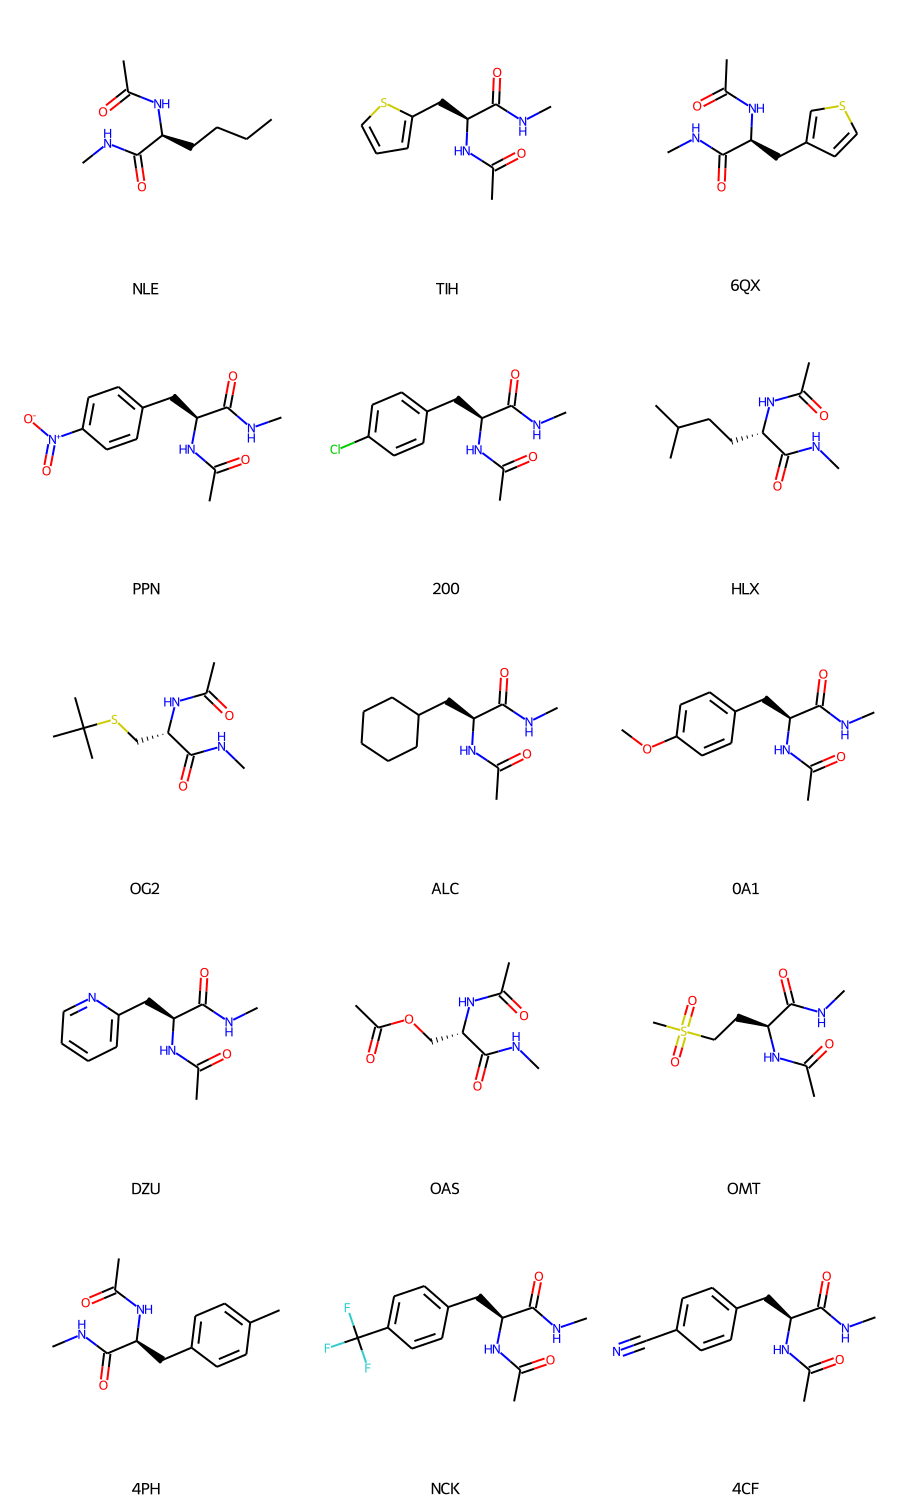

In [1]:
# read ncaa_info_complex.csv and get mol from Inchi
import os
import random
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw

char_set = ['0','1','2','3','4','5',
            '6','7','8','9','A','B',
            'C','D','E','F','G','H',
            'I','J','K','L','M','N',
            'O','P','Q','R','S','T',
            'U','V','W','X','Y','Z']

pdb_ncaa = pd.read_csv("/home/zhangf/grad_project/phase_02_validation/benchmark/ncaa_info_complex.csv")
pdb_ncaa = pdb_ncaa.values.tolist()

mols = []
for inchi, inchi_key, ncaa_entry in pdb_ncaa:
    mol = Chem.MolFromInchi(inchi)
    if type(ncaa_entry) == float: # if ncaa_entry is nan, i.e. there is no entry in pdb
        ncaa_entry = ''.join(random.sample(char_set, 3))  # give a random name from char_set
    mol.SetProp("_Name", ncaa_entry)
    print(mol.GetProp('_Name'))
    mols.append(mol)

##########

from rdkit.Chem import AllChem

modified_ncaa_mols = []

dipep_bb_mol = Chem.MolFromSmarts("CC(=O)NCC(=O)NC")
nme_mol = Chem.MolFromSmiles("C(=O)NC")
ace_mol = Chem.MolFromSmiles("NC(=O)C")
amino_mol = Chem.MolFromSmarts("N")
acid_mol = Chem.MolFromSmarts("C(=O)O")

for mol in mols:
    add_nme_mols = AllChem.ReplaceSubstructs(mol, acid_mol, nme_mol, useChirality=True)
    for mol_1 in add_nme_mols:
        add_ace_mols = AllChem.ReplaceSubstructs(mol_1, amino_mol, ace_mol, useChirality=True)  
        for mol_2 in add_ace_mols:
            if mol_2.HasSubstructMatch(dipep_bb_mol):
                Chem.SanitizeMol(mol_2)
                modified_ncaa_mols.append([mol_2, mol_2.GetProp("_Name")])



# image = Draw.MolsToGridImage([x[0] for x in modified_ncaa_mols], molsPerRow=3, subImgSize=(300,300), legends=[x[1] for x in modified_ncaa_mols])
# image


In [2]:
mol_path = "/home/zhangf/grad_project/phase_01_generation_of_database/input/mol/"
for mol, ncaa_entry in modified_ncaa_mols:
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.EmbedMultipleConfs(mol, numConfs=50)
    AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=0)

    mol.SetProp("_Name", ncaa_entry)
    ncaa_file = mol_path + ncaa_entry + ".mol"
    print(Chem.MolToMolBlock(mol), file=open(ncaa_file, 'w+'))